# OPTIONAL Workbook for Homework #8

You are welcome to work on a local version of a notebook and upload it for this assignment.

This workspace is here if you'd rather not have to install all necessary packages locally.

You can download any json files to your local computer to add them to your jekyll page.

To download, you can right-click on the file and hit download.  For example, with the following code:

```python
from vega_datasets import data
import altair as alt

source = data.cars()
source.rename(columns={"Miles_per_Gallon":"Miles per Gallon"}, 
              inplace=True)


chart = alt.Chart(source).mark_circle(size=60).encode(
    x='Horsepower',
    y='Miles per Gallon',
    color='Origin',
    tooltip=['Name', 'Origin', 'Horsepower', 'Miles per Gallon']
).interactive()

chart.properties(width='container').save("cars.json")
```

You can download from the side bar like this:

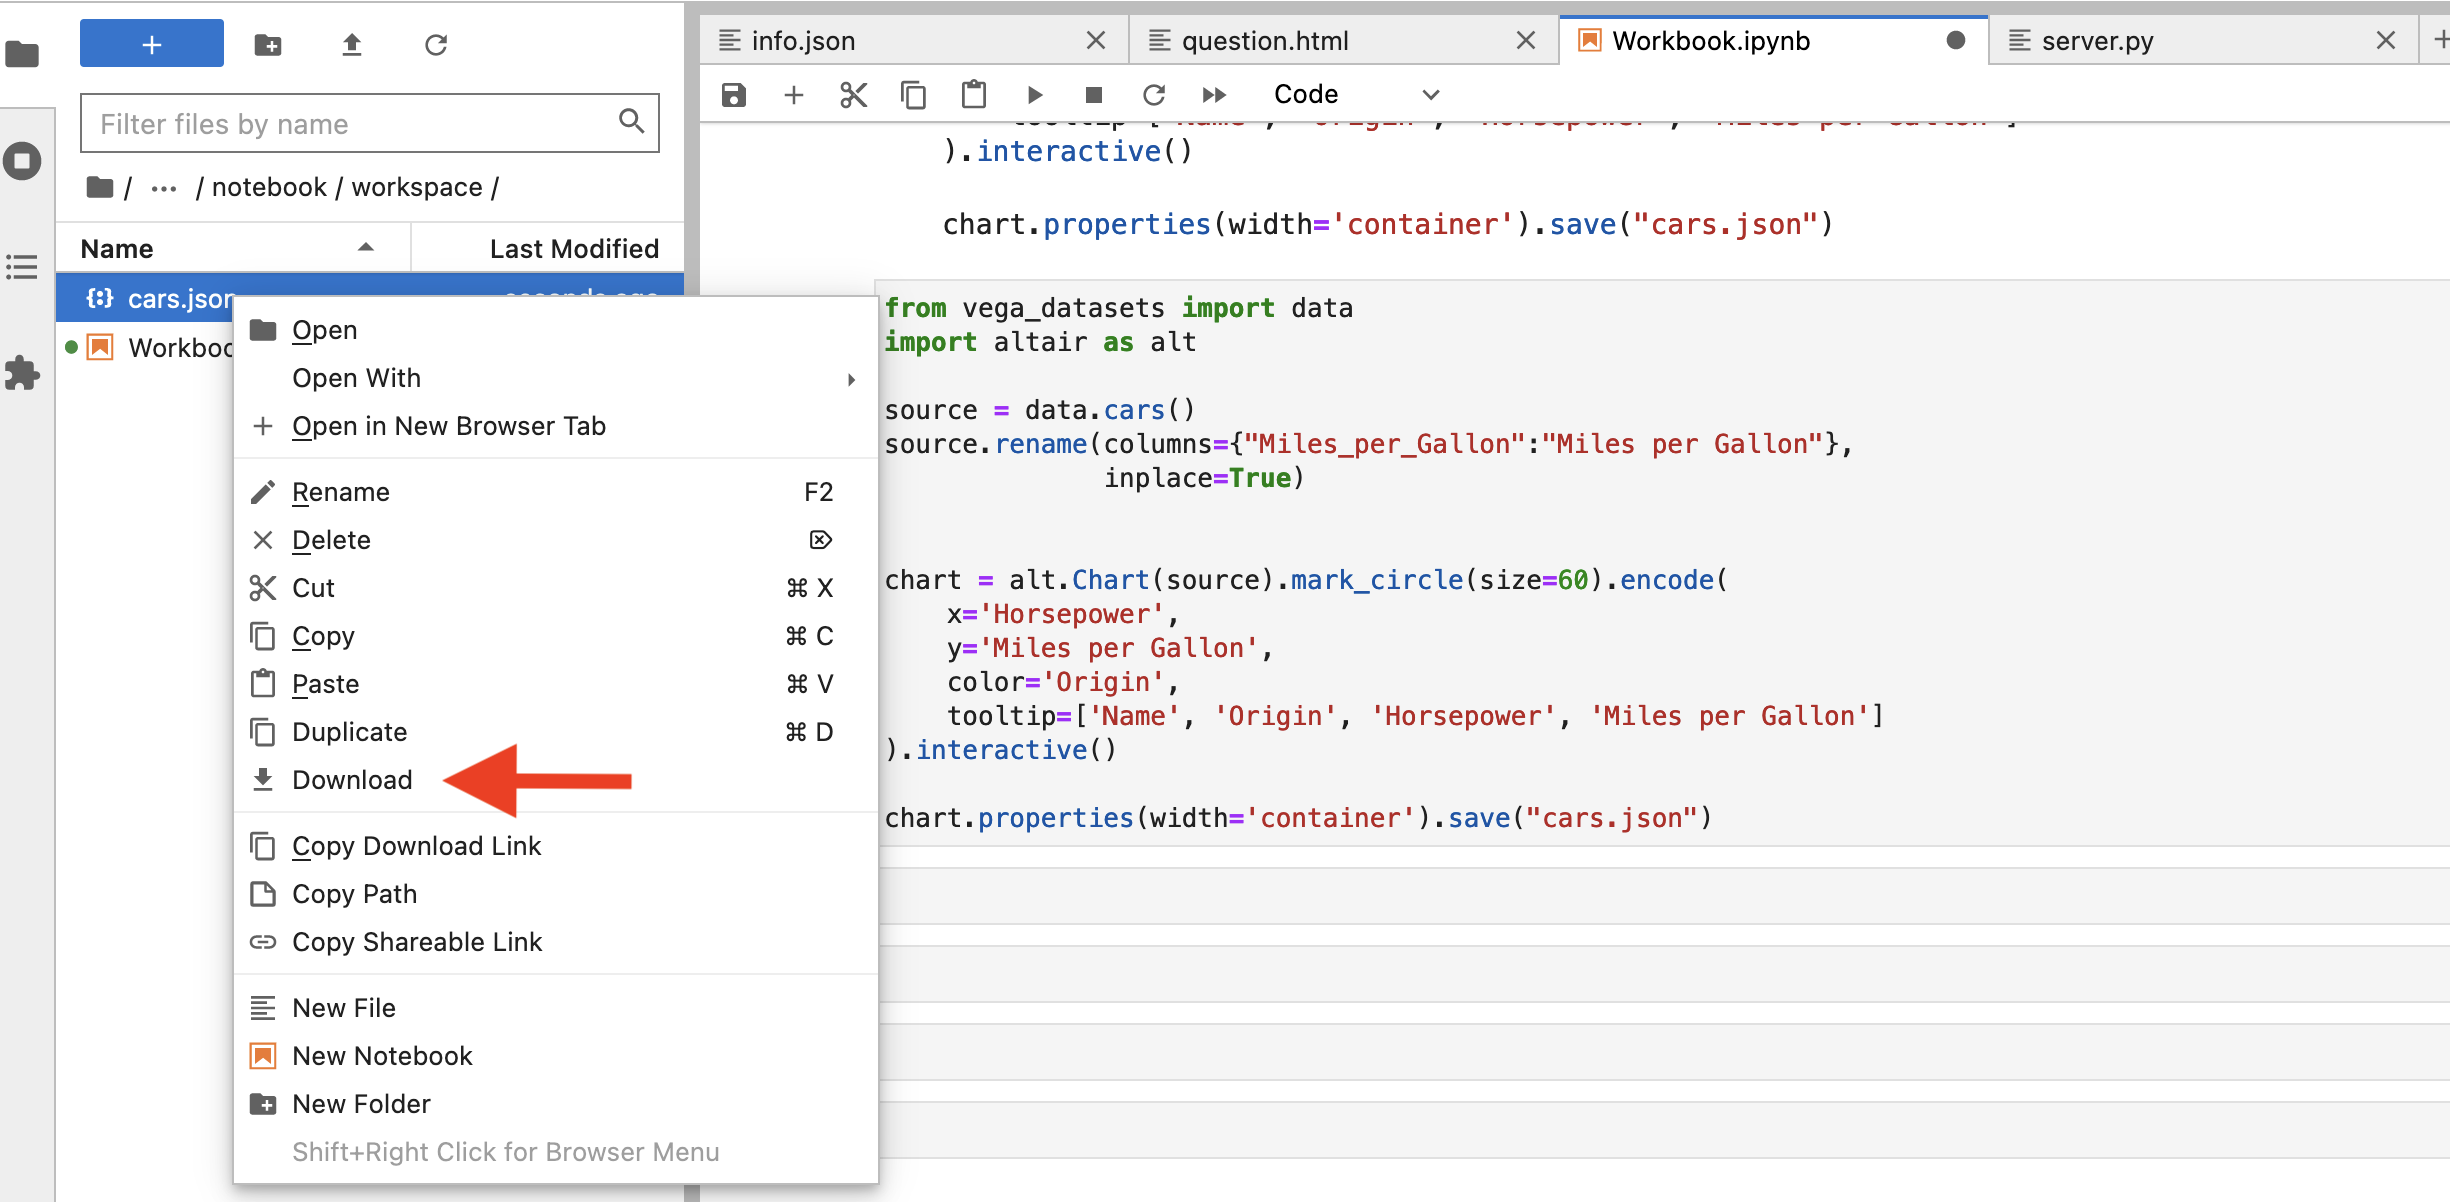

In [1]:
%pip install -q altair pandas

import pandas as pd
import altair as alt
import numpy as np

alt.data_transformers.disable_max_rows() #Disabling the rule of not displaying charts if rows more than 5000


Note: you may need to restart the kernel to use updated packages.


DataTransformerRegistry.enable('default')

In [2]:
data = "https://github.com/UIUC-iSchool-DataViz/is445_data/raw/main/ufo-scrubbed-geocoded-time-standardized-00.csv"

# Since no headers in the dataset, manually adding column names
correct_headers = ["datetime","city","state","country","shape","duration_in_seconds","duration_in_hours_min","comments","dateposted","latitude","longitude"]

df = pd.read_csv(data, header=None, names=correct_headers, low_memory=False)

In [3]:
# Converting the datetime text format in a date-time format
df["datetime"] = pd.to_datetime(df["datetime"], errors="coerce")

df = df.dropna(subset=["latitude","longitude","datetime"]) #Dropping fields with no values so plots dont break because of missing coordinates

df["year"] = df["datetime"].dt.year
df["month"] = df["datetime"].dt.month
df["weekday"] = df["datetime"].dt.day_name()
df["hour"] = df["datetime"].dt.hour

df["shape"] = df["shape"].fillna("Unknown").astype(str).str.title()

year_min = int(max(1940, np.nanmin(df["year"])))
year_max = int(min(2014, np.nanmax(df["year"])))

print("Cleaned:", len(df), "rows from", year_min, "to", year_max)
df.head(3)

Cleaned: 80332 rows from 1940 to 2014


,datetime,city,state,country,shape,duration_in_seconds,duration_in_hours_min,comments,dateposted,latitude,longitude,year,month,weekday,hour
0,1949-10-10 20:30:00,san marcos,tx,us,Cylinder,2700.0,45 minutes,This event took place in early fall around 194...,4/27/2004,29.883056,-97.941111,1949,10,Monday,20
1,1949-10-10 21:00:00,lackland afb,tx,NaN,Light,7200.0,1-2 hrs,1949 Lackland AFB&#44 TX. Lights racing acros...,12/16/2005,29.384210,-98.581082,1949,10,Monday,21
2,1955-10-10 17:00:00,chester (uk/england),NaN,gb,Circle,20.0,20 seconds,Green/Orange circular disc over Chester&#44 En...,1/21/2008,53.200000,-2.916667,1955,10,Monday,17


In [4]:
# To plot a bar chart for the UFO sightings per year

# 1) Aggregate: one row per year with a count
df_year = (
    df
    .groupby("year")
    .size()
    .reset_index(name="count")
)

# 2) Create the bar chart using the small df_year table
year_barchart = (
    alt.Chart(df_year)
    .mark_bar(color='#7E57C2')
    .encode(
        x=alt.X("year:O", title="Year"),
        y=alt.Y("count:Q", title="No. of UFO Sightings"),
        tooltip=[
            alt.Tooltip("year:O", title="Year"),
            alt.Tooltip("count:Q", title="Sightings")
        ]
    )
    .properties(
        width=870,
        height=300,
        title="UFO Sightings Per Year"
    )
)

year_barchart



alt.Chart(...)

## Plot 1: UFO Sightings Per Year (Bar Chart)

- So, for my first visualization, I am plotting a bar chart for showing the number of UFO sightings that were reported every year which will help the viewers to understand and analyse a pattern if any.

- For that, I decided to use a bar chart since its easier to display the comparison of the sightings for every year. On the X axis, I have displayed all the years as an Ordinal value since they should be displayed in a natural order, whereas on Y axis i have displayed a quantitative value ie. the count of UFO sightings. I have also added tooltips so its easier for the viewer to interpret the chart when they hover over it. Also chose a single colour for the bar chart so its not distracting the viewer from the insights that I am trying to display.
  
- For data transformation, I first loaded the data with correct headers since no headers were present in the dataset. After that I made sure to clean the data since after loadingthe dataset, the datetime column looked like 1/1/2000 23:43 which gets stored like a string and not like real dates which Python does not understand so converted these strings to real time stamps which converts the date to 2000-01-01 23:45:00 format and if no values are present it will change to NaT ie. Not a Time. 

In [5]:
#To plot a map chart for UFO Sightings per year

# Choosing random sample data since plotting circles for huge dataset can make the chart slow and messy

df_sample = df.sample(3000, random_state=1) if len(df) > 3000 else df.copy()

# To load the world map shape file
countries = alt.topo_feature(
    'https://cdn.jsdelivr.net/npm/world-atlas@2/countries-110m.json',
    'countries'
)

background = (
    alt.Chart(countries)
    .mark_geoshape(fill='#F9F9FB', stroke='#E5E7EB')
    .project(type='equalEarth')
)

# To create a year selection slider
year_bind = alt.binding_range(
    min=year_min,
    max=year_max,
    step=1,
    name='Year: '
)
year_sel = alt.selection_point(
    fields=['year'],
    bind=year_bind,
    value={'year': 2000} )

# To plot the UFO Sighting points
points = (
    alt.Chart(df_sample)
    .mark_circle(opacity=0.4)
    .encode(
        longitude='longitude:Q',
        latitude='latitude:Q',
        color=alt.Color('shape:N', title='Shape'),
        size=alt.Size(
            'duration_in_seconds:Q',
            title='Duration (seconds)',
            scale=alt.Scale(range=[10, 400])
        ),
        tooltip=[
            alt.Tooltip('datetime:T', title='Date'),
            alt.Tooltip('city:N', title='City'),
            alt.Tooltip('state:N', title='State'),
            alt.Tooltip('country:N', title='Country'),
            alt.Tooltip('shape:N', title='Shape'),
        ]
    )
    .add_params(year_sel)        # To attach the year slider to the chart
    .transform_filter(year_sel)  # To show only selected year UFO points
)

sliderplot = (
    (background + points)
    .properties(
        width=700,
        height=400,
        title="UFO Sightings by Year"
    )
)
sliderplot


alt.LayerChart(...)

## Plot 2: Interactive Map of UFO Sightings With a Year Slider

- In this visualization, I am showing the occurence of UFO sightings around the world by plotting them using the latitude and longitude which will help the users to understand in which geographic area are UFO sightings seen more and that in what area are what UFO shapes seen.

- For designing, I have used circle dots to display the UFO sightings and have placed them using the latitude(x axis) and longitude(y axis). I have also used different colours to display different shapes of UFO. Also, bigger the dot, longer the sighting lasted. I have also added tooltips so whenever the viewer hovers over the dot, they can see details like the city, state, date and shape. I have also chosen different colours for differnt shapes so that it gets easier to distinguish even if they overlap.

- For plot 2, I used the same cleaned dataset but added some extra steps like removed any empty rows from date or latitude or longitude column, since the missing values wouldve been plotted inaccurately and incorrectly. I also replaced the missing values from the shape column to 'Unknown' in order to make sure the shape column remains consistent. Also, since the dataset it very large, I took smaller random sample so its easier and efficient to plot and load the interactive bar chart. Also from the timestamp, I extracted the year field so that I can use it on the year slider.

- For interactivity, I have created a year slider, which on selection will show the listings of different shapes of UFO in different areas of the world for that particular year. This visualisation is a better updated way of displaying UFO sightings since in the bar chart, all year UFO sightings are displayed together, but here, viewer can focus on the UFO sightings from a particular year and can get more information about it like Date, City, State, Country and Shape of that UFO sighting.

In [6]:
year_barchart.properties(width='container').save("ufo_years.json")
sliderplot.properties(width='container').save("ufo_map.json")

print("Saved ufo_years.json and ufo_map.json")

Saved ufo_years.json and ufo_map.json
